## Проект: Модель выбора коров для расширения молочного хозяйства по заданнам критериям


### Описание проекта

**Цель: Разработать две модели машинного обучения:**

 - Модель прогнозирования удоя: Предсказывать годовой удой коровы.
 - Модель классификации вкуса молока: Определять вероятность получения вкусного молока от коровы.
 
**Описание данных:**

 - ferma_main.csv: Основной датасет, содержащий информацию о коровах, включая удой, характеристики молока, породу, возраст и т.д.
 - ferma_dad.csv: Дополнительные данные об отцах коров из ferma_main.csv.
 - cow_buy.csv: Данные о коровах, которых фермер хочет купить.


### План работы:

***Загрузка и предобработка данных:***
   - Загрузить все три датасета.
   - Преобразовать данные в подходящий формат (числовой, бинарный).
   - Обработать пропущенные значения (если есть).
   - Создать новые признаки (например, квадрат ЭКЕ).
   
***Разделение данных:***
   - Разделить ferma_main.csv на обучающую и тестовую выборки.
   
***Обучение моделей:***
   - Обучить две модели:
   - Линейную регрессию для прогнозирования удоя.
   - Логистическую регрессию для классификации вкуса молока.
   
***Оценка моделей:***
   - Оценить точность моделей на тестовых данных.
   - Выбрать лучшие модели по результатам оценки.
   
***Прогнозирование:***
   - Применить обученные модели к данным из cow_buy.csv.
   - Выбрать коров, которые соответствуют критериям фермера:
   - Годовой удой не менее 6000 кг.
   - Вкус молока "вкусно".

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
import re
!pip install phik -q
import phik
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from scipy.stats import skew

## Загрузка данных

In [2]:
ferma_main = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_main.csv', sep=';')
ferma_main.info()
display(ferma_main.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   id                                     634 non-null    int64 
 1   Удой, кг                               634 non-null    int64 
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    object
 3   Сырой протеин, г                       634 non-null    int64 
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    object
 5   Порода                                 634 non-null    object
 6   Тип пастбища                           634 non-null    object
 7   порода папы_быка                       634 non-null    object
 8   Жирность,%                             634 non-null    object
 9   Белок,%                                634 non-null    object
 10  Вкус молока                            634 non-null    object
 11  Возраст            

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет
3,4,5895,"12,4",2012,"0,885",РефлешнСоверинг,Холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет
4,5,5302,"12,8",1675,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,73","3,073",вкусно,менее_2_лет


In [3]:
ferma_dad = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_dad.csv', sep=';')
ferma_dad.info()
display(ferma_dad.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [4]:
cow_buy = pd.read_csv('https://code.s3.yandex.net/datasets/cow_buy.csv', sep=';')
cow_buy.info()
display(cow_buy.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Порода                   20 non-null     object
 1   Тип пастбища             20 non-null     object
 2   порода папы_быка         20 non-null     object
 3   Имя_папы                 20 non-null     object
 4   Текущая_жирность,%       20 non-null     object
 5   Текущий_уровень_белок,%  20 non-null     object
 6   Возраст                  20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB


,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,061",более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет


**Вывод:**

Первый взгляд на данные показывает, что во всех датафреймах необходимо заменить в числовых значениях запятую на точку и поменять тип с object на float.


##  Предобработка данных

Приведем названия колонок к нижнему и змениному регистру

In [5]:
# На память
# ferma_main.columns = ferma_main.columns.str.lower()
# ferma_dad.columns = ferma_dad.columns.str.lower()
# cow_buy.columns = cow_buy.columns.str.lower()
# ferma_main = ferma_main.rename(columns={'порода папы_быка': 'порода папы быка'})
# cow_buy = cow_buy.rename(columns={'порода папы_быка': 'порода папы быка'})
# cow_buy = cow_buy.rename(columns={'текущая_жирность,%': 'текущая жирность,%'})
# cow_buy = cow_buy.rename(columns={'текущий_уровень_белок,%': 'текущий уровень белок,%'})
# cow_buy = cow_buy.rename(columns={'имя_папы': 'имя папы'})

In [6]:
# Приведение названий колонок всех датафреймов в нижний регистр и к стилю snake_case через цикл(итератор) for
# import re

dfs = [
    ferma_main,
    ferma_dad,
    cow_buy
]

for df in dfs:
    df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).replace(' ', '_').lower() for i in df.columns]

ferma_main.info()
ferma_dad.info()
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   id                                     634 non-null    int64 
 1   удой,_кг                               634 non-null    int64 
 2   эке_(энергетическая_кормовая_единица)  634 non-null    object
 3   сырой_протеин,_г                       634 non-null    int64 
 4   спо_(сахаро-протеиновое_соотношение)   634 non-null    object
 5   порода                                 634 non-null    object
 6   тип_пастбища                           634 non-null    object
 7   порода_папы_быка                       634 non-null    object
 8   жирность,%                             634 non-null    object
 9   белок,%                                634 non-null    object
 10  вкус_молока                            634 non-null    object
 11  возраст            

In [7]:
# Меняем в числовых значениях запятую на точку
ferma_main[['эке_(энергетическая_кормовая_единица)',
            'спо_(сахаро-протеиновое_соотношение)',
            'жирность,%',
            'белок,%']] = \
    ferma_main[['эке_(энергетическая_кормовая_единица)',
                'спо_(сахаро-протеиновое_соотношение)',
                'жирность,%',
                'белок,%']].applymap(lambda x: str(x).replace(',', '.'))

display(ferma_main.head(5))

cow_buy[['текущая_жирность,%',
         'текущий_уровень_белок,%']] = \
    cow_buy[['текущая_жирность,%',
             'текущий_уровень_белок,%']].applymap(lambda x: str(x).replace(',', '.'))

display(cow_buy.head(5))

,id,"удой,_кг",эке_(энергетическая_кормовая_единица),"сырой_протеин,_г",спо_(сахаро-протеиновое_соотношение),порода,тип_пастбища,порода_папы_быка,"жирность,%","белок,%",вкус_молока,возраст
0,1,5863,14.2,1743,0.89,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.89,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.4,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


,порода,тип_пастбища,порода_папы_быка,имя_папы,"текущая_жирность,%","текущий_уровень_белок,%",возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.4,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [8]:
# Заменим тип данных с object на float.
ferma_main[['эке_(энергетическая_кормовая_единица)',
            'спо_(сахаро-протеиновое_соотношение)',
            'жирность,%', 'белок,%']] = \
    ferma_main[['эке_(энергетическая_кормовая_единица)',
                'спо_(сахаро-протеиновое_соотношение)',
                'жирность,%',
                'белок,%']].apply(pd.to_numeric, errors='coerce')

cow_buy[['текущая_жирность,%',
         'текущий_уровень_белок,%']] = \
    cow_buy[['текущая_жирность,%',
             'текущий_уровень_белок,%']].apply(pd.to_numeric, errors='coerce')

ferma_main.info()
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   удой,_кг                               634 non-null    int64  
 2   эке_(энергетическая_кормовая_единица)  634 non-null    float64
 3   сырой_протеин,_г                       634 non-null    int64  
 4   спо_(сахаро-протеиновое_соотношение)   634 non-null    float64
 5   порода                                 634 non-null    object 
 6   тип_пастбища                           634 non-null    object 
 7   порода_папы_быка                       634 non-null    object 
 8   жирность,%                             634 non-null    float64
 9   белок,%                                634 non-null    float64
 10  вкус_молока                            634 non-null    object 
 11  возрас

In [9]:
print(ferma_main.info())
print('-----------------------')
print(ferma_dad.info())
print('-----------------------')
print(cow_buy.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   удой,_кг                               634 non-null    int64  
 2   эке_(энергетическая_кормовая_единица)  634 non-null    float64
 3   сырой_протеин,_г                       634 non-null    int64  
 4   спо_(сахаро-протеиновое_соотношение)   634 non-null    float64
 5   порода                                 634 non-null    object 
 6   тип_пастбища                           634 non-null    object 
 7   порода_папы_быка                       634 non-null    object 
 8   жирность,%                             634 non-null    float64
 9   белок,%                                634 non-null    float64
 10  вкус_молока                            634 non-null    object 
 11  возрас

Все текстовые значения тоже приведем к нижнему регистру

In [10]:
ferma_main[['порода',
            'тип_пастбища',
            'порода_папы_быка',
            'вкус_молока',
            'возраст']] = \
    ferma_main[['порода',
                'тип_пастбища',
                'порода_папы_быка',
                'вкус_молока',
                'возраст']].apply(lambda x: x.str.lower())

# Вывод уникальных значений
print("Уникальные значения:")
print(ferma_main['порода'].unique())
print(ferma_main['вкус_молока'].unique())
print(ferma_main['возраст'].unique())
print(ferma_main['тип_пастбища'].unique())
print(ferma_main['порода_папы_быка'].unique())

ferma_dad[['имя_папы']] = ferma_dad[['имя_папы']].apply(lambda x: x.str.lower())
print(ferma_dad['имя_папы'].unique())

cow_buy[['порода',
         'тип_пастбища',
         'порода_папы_быка',
         'имя_папы',
         'возраст']] = \
    cow_buy[['порода',
             'тип_пастбища',
             'порода_папы_быка',
             'имя_папы',
             'возраст']].apply(lambda x: x.str.lower())

print(cow_buy['порода'].unique())
print(cow_buy['возраст'].unique())
print(cow_buy['тип_пастбища'].unique())
print(cow_buy['имя_папы'].unique())
print(cow_buy['порода_папы_быка'].unique())

Уникальные значения:
['вис бик айдиал' 'рефлешнсоверинг']
['вкусно' 'не вкусно']
['более_2_лет' 'менее_2_лет']
['равнинное' 'равнинные' 'холмистое']
['айдиал' 'соверин' 'айдиалл']
['буйный' 'соловчик' 'барин' 'геркулес']
['вис бик айдиал' 'рефлешнсоверинг']
['более_2_лет' 'менее_2_лет']
['холмистое' 'равнинное']
['геркулес' 'буйный' 'барин' 'соловчик']
['айдиал' 'соверин']


In [11]:
# Замена значений 
ferma_main['порода_папы_быка'] = ferma_main['порода_папы_быка'].replace('айдиалл', 'айдиал')
ferma_main['порода'] = ferma_main['порода'].replace('рефлешнсоверинг', 'рефлешн_соверинг')
ferma_main['тип_пастбища'] = ferma_main['тип_пастбища'].replace('равнинные', 'равнинное')
cow_buy['порода'] = cow_buy['порода'].replace('рефлешнсоверинг', 'рефлешн_соверинг')

# Вывод уникальных значений
print("Уникальные значения:")
print(ferma_main['порода'].unique())
print(ferma_main['вкус_молока'].unique())
print(ferma_main['возраст'].unique())
print(ferma_main['тип_пастбища'].unique())
print(ferma_main['порода_папы_быка'].unique())

ferma_dad[['имя_папы']] = ferma_dad[['имя_папы']].apply(lambda x: x.str.lower())
print(ferma_dad['имя_папы'].unique())

cow_buy[['порода',
         'тип_пастбища',
         'порода_папы_быка',
         'имя_папы',
         'возраст']] = \
    cow_buy[['порода',
             'тип_пастбища',
             'порода_папы_быка',
             'имя_папы',
             'возраст']].apply(lambda x: x.str.lower())

print(cow_buy['порода'].unique())
print(cow_buy['возраст'].unique())
print(cow_buy['тип_пастбища'].unique())
print(cow_buy['имя_папы'].unique())
print(cow_buy['порода_папы_быка'].unique())

Уникальные значения:
['вис бик айдиал' 'рефлешн_соверинг']
['вкусно' 'не вкусно']
['более_2_лет' 'менее_2_лет']
['равнинное' 'холмистое']
['айдиал' 'соверин']
['буйный' 'соловчик' 'барин' 'геркулес']
['вис бик айдиал' 'рефлешн_соверинг']
['более_2_лет' 'менее_2_лет']
['холмистое' 'равнинное']
['геркулес' 'буйный' 'барин' 'соловчик']
['айдиал' 'соверин']


In [12]:
# Пропуски
print(f'\n{ferma_main.isna().sum()}')
print(f'\n{ferma_dad.isna().sum()}')
print(f'\n{cow_buy.isna().sum()}')


id                                       0
удой,_кг                                 0
эке_(энергетическая_кормовая_единица)    0
сырой_протеин,_г                         0
спо_(сахаро-протеиновое_соотношение)     0
порода                                   0
тип_пастбища                             0
порода_папы_быка                         0
жирность,%                               0
белок,%                                  0
вкус_молока                              0
возраст                                  0
dtype: int64

id          0
имя_папы    0
dtype: int64

порода                     0
тип_пастбища               0
порода_папы_быка           0
имя_папы                   0
текущая_жирность,%         0
текущий_уровень_белок,%    0
возраст                    0
dtype: int64


In [13]:
# Находим и удаляем все дубликаты
print(ferma_main.duplicated().sum())
print(ferma_dad.duplicated().sum())
print(cow_buy.duplicated().sum())

5
0
4


В ferma_dad отсутствуют дубликаты. cow_buy - это тестовая выборка, по которой модельдолжна предсказать удой и вкус молока не зависимо от того есть ли там дубликаты, поэтому оставляем эту выборку неизменной. А вот в выборке ferma_main присутствуют дубликаты, которые необходимо удалить. Почему?

Дубликаты могут негативно влиять на обучение моделей машинного обучения, а именно:
- модель будет больше учиться на дубликатах, и меньше учитывать из-за них другие значения, что может привести к нерпавильному предсказанию на новых данных;
- модель обученная на дубликатах, может переобучиться и предсказывать хуже на новых данных.

In [14]:
ferma_main = ferma_main.drop_duplicates()
print(ferma_main.duplicated().sum())

0


**Вывод:**

1. Заменены запятые на точки в числовых столбцах датафреймов ferma_main и cow_buy.
2. Изменен тип данных в этих столбцах с object на float.
3. Унифицированы названия столбцов в датафреймах: приведены к нижнему регистру в стиде snake_case.
4. Обнаружены и удалены дубликаты из ferma_main.

## Исследовательский анализ данных

Выведем сатистическое описание каждого стобца из датасета ferma_main и проверим на аномалии.

In [15]:
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     629 non-null    int64  
 1   удой,_кг                               629 non-null    int64  
 2   эке_(энергетическая_кормовая_единица)  629 non-null    float64
 3   сырой_протеин,_г                       629 non-null    int64  
 4   спо_(сахаро-протеиновое_соотношение)   629 non-null    float64
 5   порода                                 629 non-null    object 
 6   тип_пастбища                           629 non-null    object 
 7   порода_папы_быка                       629 non-null    object 
 8   жирность,%                             629 non-null    float64
 9   белок,%                                629 non-null    float64
 10  вкус_молока                            629 non-null    object 
 11  возрас

In [16]:
ferma_main.describe()

,id,"удой,_кг",эке_(энергетическая_кормовая_единица),"сырой_протеин,_г",спо_(сахаро-протеиновое_соотношение),"жирность,%","белок,%"
count,629.00000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,315.00000,6188.750397,14.543879,1923.364070,0.913116,3.603657,3.075671
std,181.72094,1644.795489,1.306408,182.956251,0.032203,0.168656,0.002549
min,1.00000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,158.00000,5751.000000,13.500000,1771.000000,0.890000,3.590000,3.074000
50%,315.00000,6133.000000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,472.00000,6501.000000,15.600000,2062.000000,0.940000,3.720000,3.077000
max,629.00000,45616.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


Видим аномальное значение в поле "Удой". Отсортируем данное поле по убыванию и выведем 10 первых значений.

In [17]:
print(ferma_main['удой,_кг'].sort_values(ascending=False).head(10))

16     45616
70      7222
135     7207
296     7201
294     7197
593     7174
46      7173
176     7141
264     7133
194     7113
Name: удой,_кг, dtype: int64


Аномальное значение только одно, удалим строку с данным значением.

In [18]:
# Удаление аномалбного значения
ferma_main = ferma_main.drop(index=16)
print(ferma_main['удой,_кг'].sort_values(ascending=False).head(10))

70     7222
135    7207
296    7201
294    7197
593    7174
46     7173
176    7141
264    7133
503    7113
194    7113
Name: удой,_кг, dtype: int64


**Вывод:**

Обнаружено аномальное значение “Удой” (45616 кг). Данное значение вероятно является ошибочным и удалено из датасета.

Далее построим гистограммы для всех числовых значений в выборке ferma_main

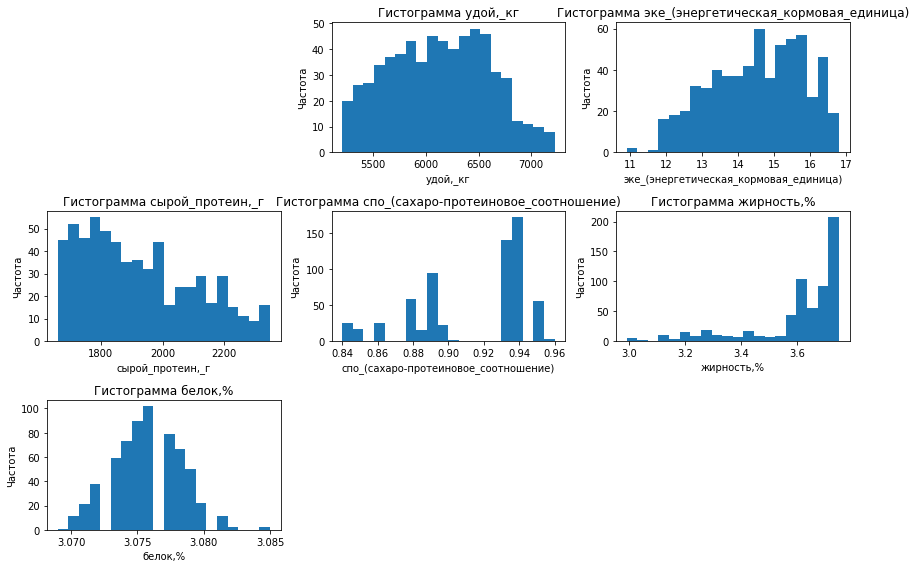

In [19]:
# Гистограммы
plt.figure(figsize=(12, 8))
for i, column in enumerate(ferma_main.select_dtypes(include=['number']).columns):
    if column != 'id':
        plt.subplot(3, 3, i + 1)
        plt.hist(ferma_main[column], bins=20)
        plt.title(f'Гистограмма {column}')
        plt.xlabel(column)
        plt.ylabel('Частота')
plt.tight_layout()
plt.show()

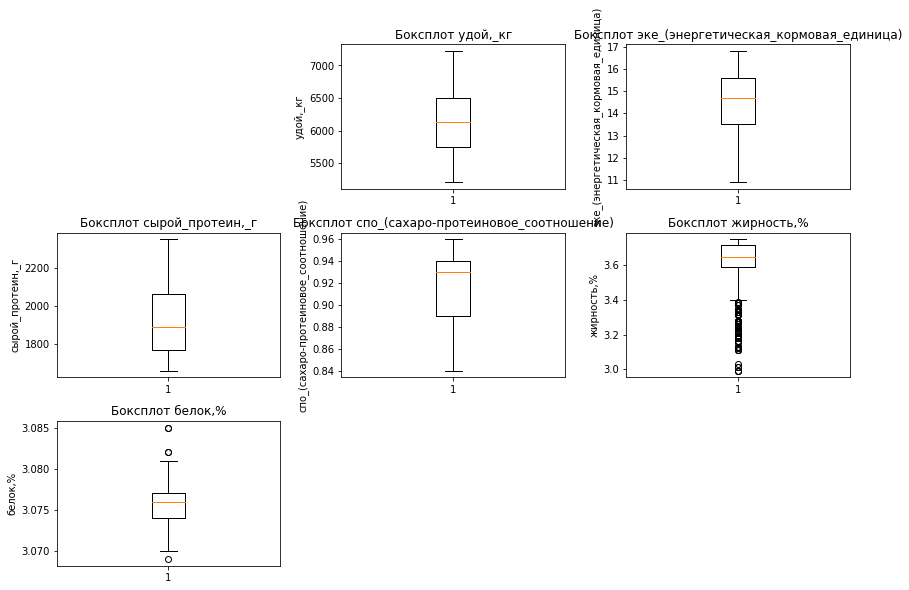

In [20]:
plt.figure(figsize=(12, 8))  # Вы можете изменить размер фигуры по желанию
for i, column in enumerate(ferma_main.select_dtypes(include=['number']).columns):
    # Пропускаем столбец 'id'
    if column == 'id':
        continue

    plt.subplot(3, 3, i + 1)  # Изменяем на (3, 2) для 6 подграфиков
    plt.boxplot(ferma_main[column])
    plt.title(f'Боксплот {column}')
    plt.ylabel(column)
plt.tight_layout()
plt.show()

In [21]:
# Давайте мы попробуем охарактеризовать гистограммы при помощи числовых значений
for column in ferma_main.select_dtypes(include=['number']).columns:
    if column != 'id':
        # Расчет характеристик
        mean = ferma_main[column].mean() 
        median = ferma_main[column].median() 
        std = ferma_main[column].std() 
        skew = ferma_main[column].skew() 
        kurt = ferma_main[column].kurt() 
        
        # Вычисление IQR
        q1 = ferma_main[column].quantile(0.25)
        q3 = ferma_main[column].quantile(0.75)
        iqr = q3 - q1

        print(f'--- {column} ---')
        print(f'Среднее: {mean}')
        print(f'Медиана: {median}')
        print(f'Стандартное отклонение: {std}')
        print(f'IQR: {iqr}') # Добавляем IQR
        print(f'Асимметрия: {skew}')
        print(f'Куртозис: {kurt}')
        print('---')

--- удой,_кг ---
Среднее: 6125.968152866242
Медиана: 6132.5
Стандартное отклонение: 475.85705331358616
IQR: 751.25
Асимметрия: 0.03223787829859327
Куртозис: -0.8375095853912806
---
--- эке_(энергетическая_кормовая_единица) ---
Среднее: 14.548726114649678
Медиана: 14.7
Стандартное отклонение: 1.301777083063757
IQR: 2.0999999999999996
Асимметрия: -0.295683199148544
Куртозис: -0.8042394612063815
---
--- сырой_протеин,_г ---
Среднее: 1923.7595541401274
Медиана: 1888.0
Стандартное отклонение: 182.83281550454566
IQR: 290.5
Асимметрия: 0.5166846527196526
Куртозис: -0.7773445972971338
---
--- спо_(сахаро-протеиновое_соотношение) ---
Среднее: 0.9130891719745222
Медиана: 0.93
Стандартное отклонение: 0.03222124984506393
IQR: 0.04999999999999993
Асимметрия: -0.6885101884183454
Куртозис: -0.7620804422908876
---
--- жирность,% ---
Среднее: 3.604267515923566
Медиана: 3.65
Стандартное отклонение: 0.16809260689673733
IQR: 0.13000000000000034
Асимметрия: -1.694953803895783
Куртозис: 2.0264830798852635
-

In [22]:
# На память
# Вычисление числовых характеристик боксплотов
# for column in ferma_main.select_dtypes(include=['number']).columns:
#     # Пропускаем столбец 'id'
#     if column == 'id':
#         continue

#     # Вычисление значений
#     q1 = ferma_main[column].quantile(0.25)
#     q2 = ferma_main[column].quantile(0.5)  # Медиана
#     q3 = ferma_main[column].quantile(0.75)
#     iqr = q3 - q1 
#     lower_whisker = q1 - 1.5 * iqr
#     upper_whisker = q3 + 1.5 * iqr

#     print(f'--- {column} ---')
#     print(f'Q1: {q1}')
#     print(f'Медиана (Q2): {q2}')
#     print(f'Q3: {q3}')
#     print(f'IQR: {iqr}')
#     print(f'Нижний ус: {lower_whisker}')
#     print(f'Верхний ус: {upper_whisker}')
#     print('---')

**Критерии оценки результатов:**

**1.Стандартное отклонение:**

- ***Большое отклонение:*** Стандартное отклонение (Standard Deviation) характеризует разброс данных относительно среднего значения. Большое стандартное отклонение означает, что данные более разбросаны, значения сильно отличаются от среднего.
- ***Маленькое отклонение:*** Маленькое стандартное отклонение означает, что данные более сгруппированы вокруг среднего значения, значения ближе к среднему.
- ***Интерпретация:*** Большое стандартное отклонение может указывать на большую вариативность в данных. Маленькое стандартное отклонение указывает на меньшую вариативность.
- ***Большое отклонение:*** Стандартное отклонение больше чем 1.5 * IQR
- ***Маленькое отклонение:*** Стандартное отклонение меньше чем 0.5 * IQR.
- ***IQR***: межквартильный размах (Interquartile Range). Это мера разброса данных, которая описывает разницу между третьим и первым квартилями распределения. IQR = Q3 - Q1 (Первый квартиль (Q1) - 25% данных меньше этого значения. Второй квартиль (Q2) - это медиана (50% данных меньше этого значения).Третий квартиль (Q3) - 75% данных меньше этого значения.

**2.Асимметрия:**

- ***Положительная асимметрия:*** Хвост гистограммы длиннее в сторону больших значений. Среднее значение больше медианного.
- ***Отрицательная асимметрия:*** Хвост гистограммы длиннее в сторону меньших значений. Среднее значение меньше медианного.
- ***Симметрия:*** Асимметрия равна нулю или близка к нулю, гистограмма симметрична.
- ***Интерпретация:*** Асимметрия указывает на неравномерность распределения данных. Положительная асимметрия может указывать на наличие выбросов в сторону больших значений. Отрицательная асимметрия может указывать на наличие выбросов в сторону меньших значений.
- ***Большая асимметрия:*** Асимметрия больше чем 1 или меньше чем -1
- ***Маленькая асимметрия:*** Асимметрия между -1 и 1

**3.Куртозис:**

- ***Высокий куртозис:*** Гистограмма более остроконечная и имеет более длинные хвосты в сторону больших и меньших значений
- ***Низкий куртозис:*** Гистограмма более “плоская” и имеет более короткие хвосты.
- ***Нормальное распределение:*** Куртозис равен 3.
- ***Интерпретация:*** Куртозис указывает на “заостренность” распределения данных. Высокий куртозис может указывать на наличие большего количества выбросов или большую концентрацию значений вокруг среднего. Низкий куртозис указывает на более равномерное распределение данных.
- ***Высокий куртозис:*** Куртозис больше чем 5
- ***Низкий куртозис:*** Куртозис меньше чем 1

**Основные выводы:**
- Удой, кг: Данные распределены практически симметрично близко к нормальному распределению
- ЭКЕ (энергетическая кормовая единица): Распределение немного смещено в сторону более низких значений, но вариативность небольшая
- Сырой протеин, г: Распределение немного смещено в сторону более высоких значений
- СПО (Сахаро-протеиновое соотношение): Распределение смещено в сторону более низких значений. На гистограмме четко видно как значения разделены на несколько отдельных групп.  С учетом всех данных имеет смысл этот столбец перевести в категориальную шкалу
- Жирность, %: Очень высокая ассиметрия. Распределение сильно смещено в сторону более низких значений, что подтверждается блокспотом. С учетом всех данных имеет смысл этот столбец перевести в категориальную шкалу
- Белок, %: Распределение практически симметричное и очень стабильное

На основе столбцов числовых СПО и Жирность, создадим новые категориальные 'спо_категория' и 'жирность_категория'.

In [23]:
ferma_main[['спо_(сахаро-протеиновое_соотношение)', 'жирность,%']].describe()

,спо_(сахаро-протеиновое_соотношение),"жирность,%"
count,628.000000,628.000000
mean,0.913089,3.604268
std,0.032221,0.168093
min,0.840000,2.990000
25%,0.890000,3.590000
50%,0.930000,3.650000
75%,0.940000,3.720000
max,0.960000,3.750000


In [24]:
# Функция pd.cut() из библиотеки pandas используется для разбиения данных на категории.
ferma_main['спо_категория'] = pd.cut(ferma_main['спо_(сахаро-протеиновое_соотношение)'], 
                                        bins=[0.84, 0.92, 0.96], 
                                        labels=['спо_менее_0.9', 'спо_более_0.9'],
                                        include_lowest=True) #нижняя граница первого интервала должна включаться в категорию

ferma_main['жирность_категория'] = pd.cut(ferma_main['жирность,%'], 
                                        bins=[2.99, 3.6, 3.7, 3.75], 
                                        labels=['Низкая', 'Средняя', 'Высокая'],
                                        include_lowest=True)
ferma_main.info()
display(ferma_main[['спо_категория', 'жирность_категория']].head(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 628 entries, 0 to 628
Data columns (total 14 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   id                                     628 non-null    int64   
 1   удой,_кг                               628 non-null    int64   
 2   эке_(энергетическая_кормовая_единица)  628 non-null    float64 
 3   сырой_протеин,_г                       628 non-null    int64   
 4   спо_(сахаро-протеиновое_соотношение)   628 non-null    float64 
 5   порода                                 628 non-null    object  
 6   тип_пастбища                           628 non-null    object  
 7   порода_папы_быка                       628 non-null    object  
 8   жирность,%                             628 non-null    float64 
 9   белок,%                                628 non-null    float64 
 10  вкус_молока                            628 non-null    object 

,спо_категория,жирность_категория
0,спо_менее_0.9,Низкая
1,спо_менее_0.9,Низкая
2,спо_менее_0.9,Низкая
3,спо_менее_0.9,Низкая
4,спо_менее_0.9,Высокая
5,спо_менее_0.9,Низкая
6,спо_менее_0.9,Низкая
7,спо_более_0.9,Низкая
8,спо_более_0.9,Высокая
9,спо_менее_0.9,Низкая


In [25]:
print(ferma_main['спо_категория'].value_counts())
print(ferma_main['жирность_категория'].value_counts())

спо_более_0.9    370
спо_менее_0.9    258
Name: спо_категория, dtype: int64
Высокая    285
Средняя    172
Низкая     171
Name: жирность_категория, dtype: int64


## Корреляционный анализ

In [26]:
ferma_main.info()
display(ferma_main.head(5))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 628 entries, 0 to 628
Data columns (total 14 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   id                                     628 non-null    int64   
 1   удой,_кг                               628 non-null    int64   
 2   эке_(энергетическая_кормовая_единица)  628 non-null    float64 
 3   сырой_протеин,_г                       628 non-null    int64   
 4   спо_(сахаро-протеиновое_соотношение)   628 non-null    float64 
 5   порода                                 628 non-null    object  
 6   тип_пастбища                           628 non-null    object  
 7   порода_папы_быка                       628 non-null    object  
 8   жирность,%                             628 non-null    float64 
 9   белок,%                                628 non-null    float64 
 10  вкус_молока                            628 non-null    object 

,id,"удой,_кг",эке_(энергетическая_кормовая_единица),"сырой_протеин,_г",спо_(сахаро-протеиновое_соотношение),порода,тип_пастбища,порода_папы_быка,"жирность,%","белок,%",вкус_молока,возраст,спо_категория,жирность_категория
0,1,5863,14.2,1743,0.890,вис бик айдиал,равнинное,айдиал,3.58,3.076,вкусно,более_2_лет,спо_менее_0.9,Низкая
1,2,5529,12.8,2138,0.890,вис бик айдиал,равнинное,соверин,3.54,3.079,вкусно,менее_2_лет,спо_менее_0.9,Низкая
2,3,5810,14.0,1854,0.885,рефлешн_соверинг,холмистое,соверин,3.59,3.074,не вкусно,более_2_лет,спо_менее_0.9,Низкая
3,4,5895,12.4,2012,0.885,рефлешн_соверинг,холмистое,айдиал,3.40,3.075,не вкусно,более_2_лет,спо_менее_0.9,Низкая
4,5,5302,12.8,1675,0.885,вис бик айдиал,равнинное,соверин,3.73,3.073,вкусно,менее_2_лет,спо_менее_0.9,Высокая


### Изучите взаимосвязь между признаками: рассчитайте коэффициенты корреляции между всеми признаками.

Используем библиотеку  phik. Она автоматически определяет тип данных в столбцах и применяет соответствующий метод корреляции. По умолчанию phik рассчитывает корреляцию как для количественных, так и для категориальных столбцов. Поэтому  вывод матрицы корреляции включает все признаки, и phik сам определяет, какой метод корреляции применить к каждому признаку.

interval columns not set, guessing: ['удой,_кг', 'эке_(энергетическая_кормовая_единица)', 'сырой_протеин,_г', 'спо_(сахаро-протеиновое_соотношение)', 'жирность,%', 'белок,%']


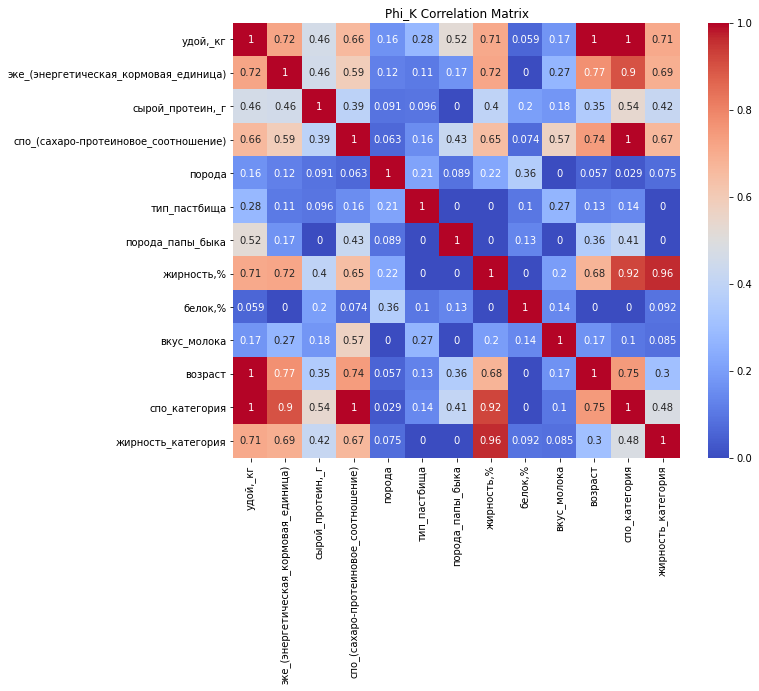

In [27]:
# !pip install phik -q
# import phik
# import seaborn as sns

# Исключим столбец 'id' из корреляции
ferma_main_corr = ferma_main.drop('id', axis=1)

# Вычисление  матрицы  корреляции:
corr_matrix = ferma_main_corr.phik_matrix()

# Визуализация  матрицы  корреляции:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

In [28]:
print(corr_matrix)

                                       удой,_кг  \
удой,_кг                               1.000000   
эке_(энергетическая_кормовая_единица)  0.720719   
сырой_протеин,_г                       0.463224   
спо_(сахаро-протеиновое_соотношение)   0.661359   
порода                                 0.164744   
тип_пастбища                           0.279540   
порода_папы_быка                       0.519915   
жирность,%                             0.707654   
белок,%                                0.058970   
вкус_молока                            0.173122   
возраст                                0.998101   
спо_категория                          0.999947   
жирность_категория                     0.708362   

                                       эке_(энергетическая_кормовая_единица)  \
удой,_кг                                                            0.720719   
эке_(энергетическая_кормовая_единица)                               1.000000   
сырой_протеин,_г                             

In [29]:
# # На память
# # Рассчет корреляции
# correlation_matrix = ferma_main.corr()

# # Вывод корреляционной матрицы
# print(correlation_matrix)

# # Визуализация корреляционной матрицы
# import matplotlib.pyplot as plt
# import seaborn as sns

# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# plt.show()

Нам болле остальных важны 2 целевых признака: удой и вкус молока. На основе полученных данных сделаем выводы о коррелляции этих признаков с другими.

**Выводы:**
1. Удой,кг: ключевыми факторами, влияющими на удой, являются возраст коровы(0.99) спо_категория(КК*=0.81), ЭКЕ(КК=0.72), жирность(КК=0.7), СПО(КК=0.66).
2. Вкус молока: не наблюдается сильных взаимосвязей вкуса молока сдругими признаками. Вкус молока связан с СПО(КК=0.57), но связь также не сильная.

*КК - коэф.корреляции*

### Построим диаграммы рассеяния scatterplot для признака Удой, кг и всех количественных признаков с учётом значения категориальных признаков. Будем учитывать, что виды связи в подгруппах могут различаться — например, для разных пород.

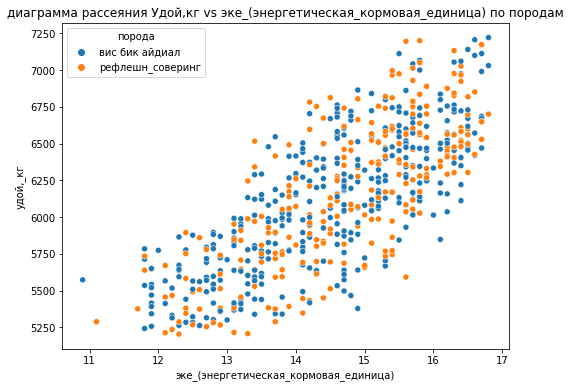

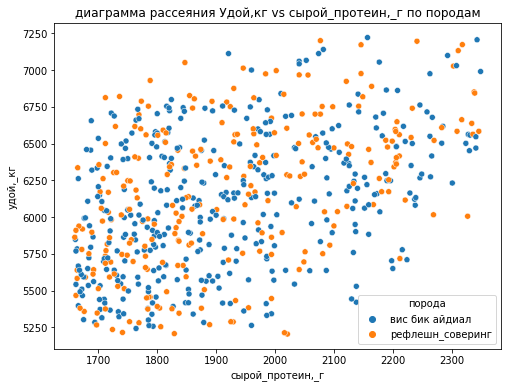

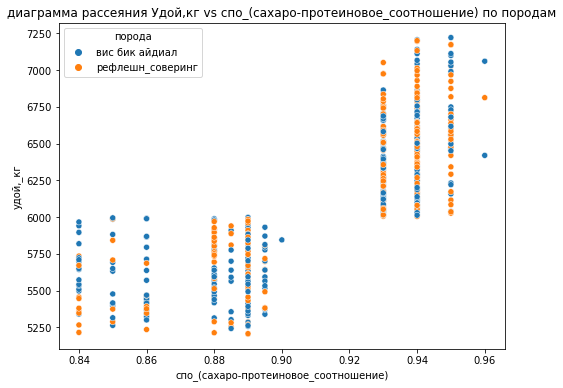

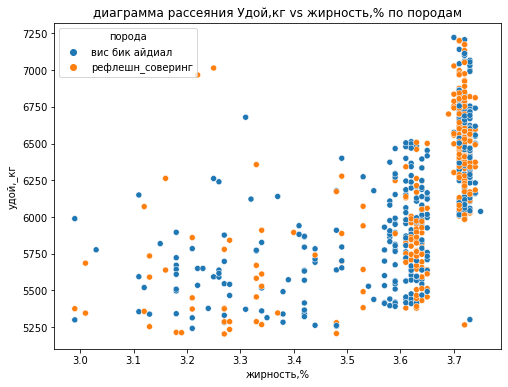

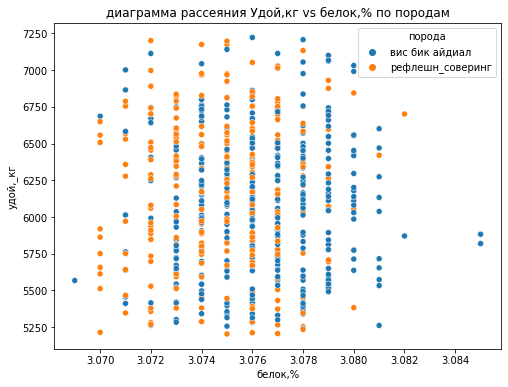

In [30]:
# Список количественных признаков
quantitative_features = ['эке_(энергетическая_кормовая_единица)',
                         'сырой_протеин,_г',
                         'спо_(сахаро-протеиновое_соотношение)',
                         'жирность,%',
                         'белок,%']

# Построение диаграмм рассеяния
for feature in quantitative_features:
    if feature != 'удой,_кг':
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=ferma_main[feature], y=ferma_main['удой,_кг'], hue=ferma_main['порода'])
        plt.xlabel(feature)
        plt.ylabel('удой,_кг')
        plt.title(f'диаграмма рассеяния Удой,кг vs {feature} по породам')
        plt.show()

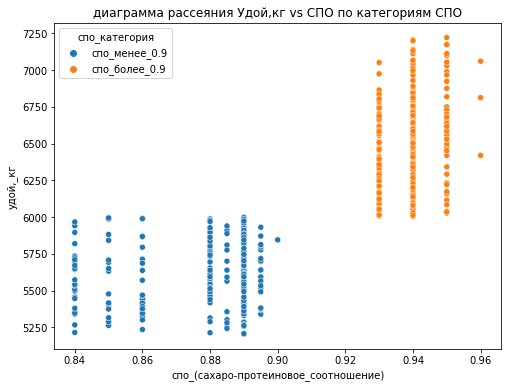

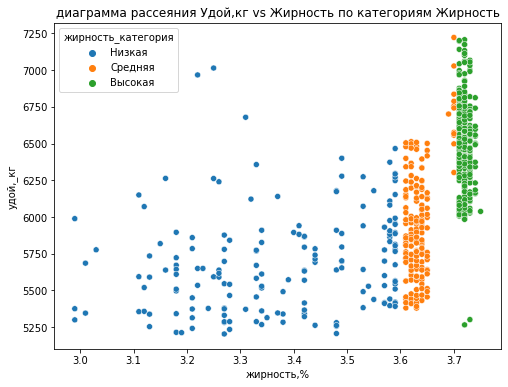

In [31]:
# 1. Нелинейность с СПО
plt.figure(figsize=(8, 6))
sns.scatterplot(x=ferma_main['спо_(сахаро-протеиновое_соотношение)'], y=ferma_main['удой,_кг'], hue=ferma_main['спо_категория'])
plt.xlabel('спо_(сахаро-протеиновое_соотношение)')
plt.ylabel('удой,_кг')
plt.title('диаграмма рассеяния Удой,кг vs СПО по категориям СПО')
plt.show()

# 2. Нелинейность с жирностью
plt.figure(figsize=(8, 6))
sns.scatterplot(x=ferma_main['жирность,%'], y=ferma_main['удой,_кг'], hue=ferma_main['жирность_категория'])
plt.xlabel('жирность,%')
plt.ylabel('удой,_кг')
plt.title('диаграмма рассеяния Удой,кг vs Жирность по категориям Жирность')
plt.show()

Видна нелинейная зависимость Удоя от категорий СПО и жирности

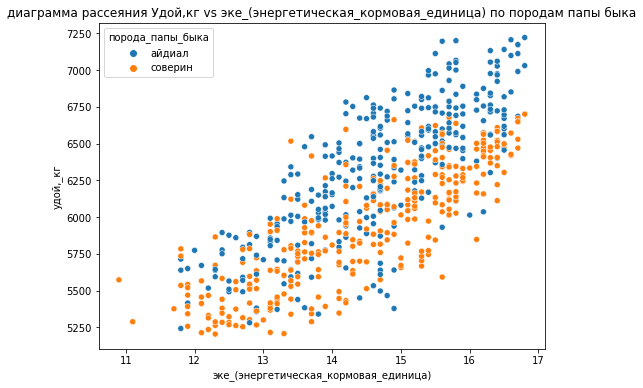

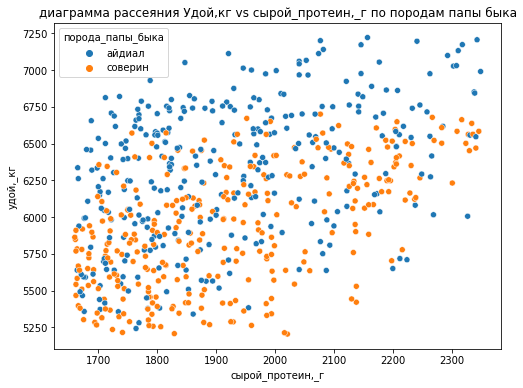

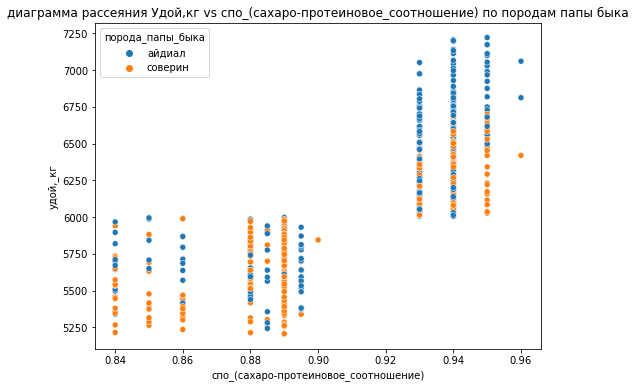

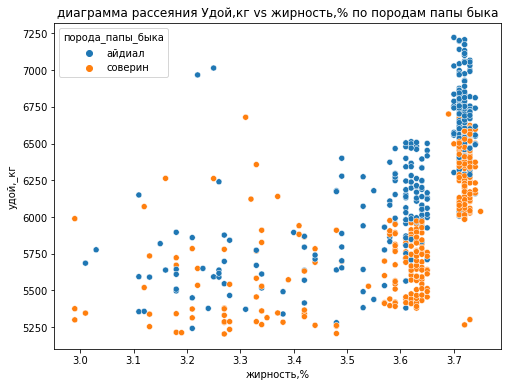

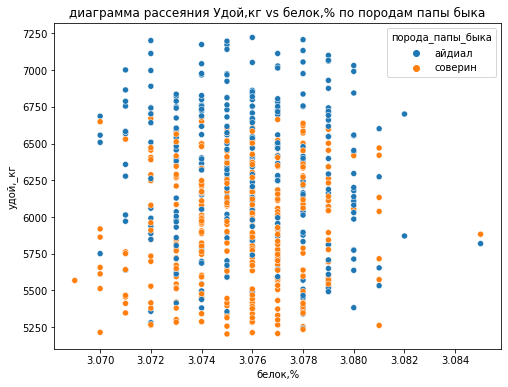

In [32]:
# 3. Влияние "Порода папы быка"

for feature in quantitative_features:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=ferma_main[feature], y=ferma_main['удой,_кг'], hue=ferma_main['порода_папы_быка'])
    plt.xlabel(feature)
    plt.ylabel('удой,_кг')
    plt.title(f'диаграмма рассеяния Удой,кг vs {feature} по породам папы быка')
    plt.show()


По диаграммам видно, что коровы у которых порода папы быка Айдиал имеют удой больше, чем Соверин

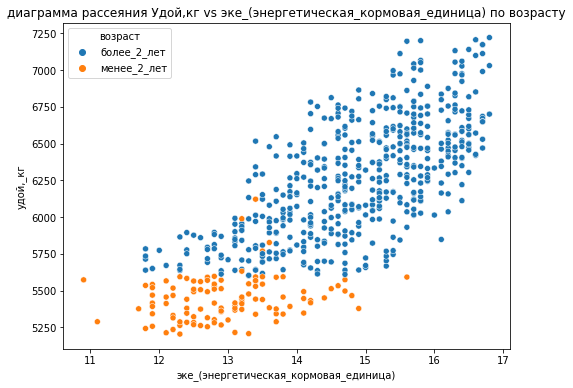

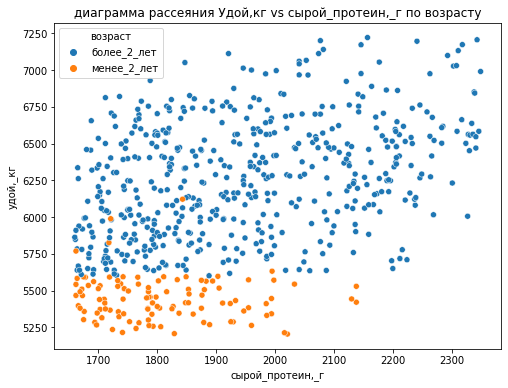

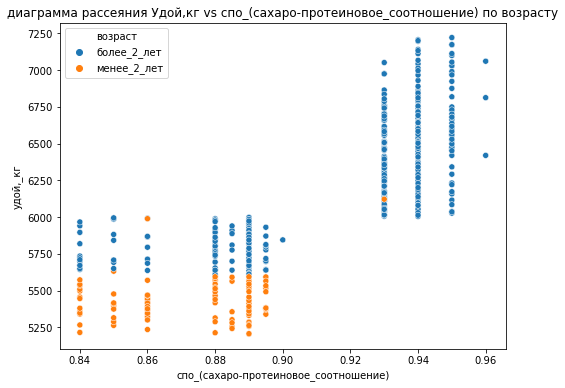

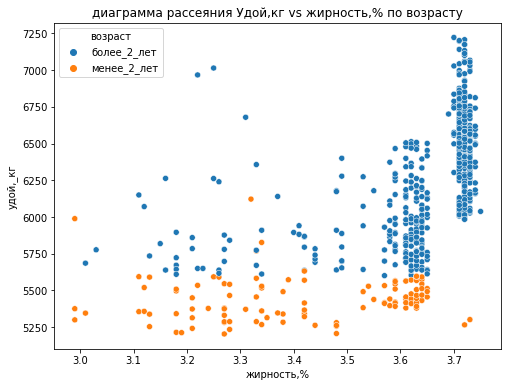

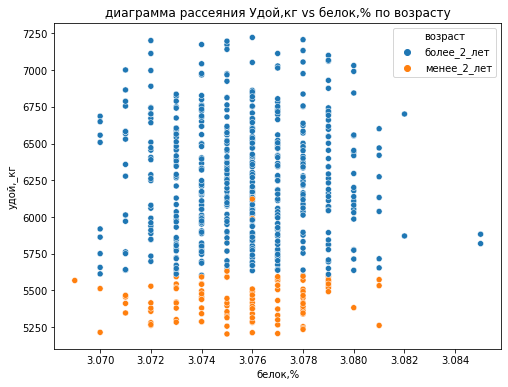

In [33]:
# 4. Влияние возраста
for feature in quantitative_features:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=ferma_main[feature], y=ferma_main['удой,_кг'], hue=ferma_main['возраст'])
    plt.xlabel(feature)
    plt.ylabel('удой,_кг')
    plt.title(f'диаграмма рассеяния Удой,кг vs {feature} по возрасту')
    plt.show()

По диаграммам видим очень сильное влияние возраста коров на удой, также видно, что ко второй категории с повышенным СПО относятся практически только коровы возрастом более двух лет.

### Сделайте выводы о взаимосвязи признаков.
Какой тип взаимосвязи между целевым и входными признаками?
<br>Есть ли нелинейные связи между целевым и входными признаками? 
<br>Нужно ли вводить в модель дополнительные признаки, чтобы это учесть?
<br>Наблюдается ли мультиколлинеарность между входными признаками?

Проанализировав диаграммы рассеяния и корреляционную матрицу, можно сделать следующие выводы о взаимосвязи признаков в датасете ferma_main.csv:

1. Есть не линейность с спо и жирностью во всех группах. Однозначно стоит создавать новые факторы.
2. В группах "порода_папы_быка" разный уровень корреляции по всем факторам. Т.е. есть отличия от корреляции по всей таблице. Скорее всего, "папа" сильнее влияет на удой, чем остальные факторы
3. Мультиколлинеарности скорее всего нет (нет "узкого облака", похожего на четкую линейную зависимость)
4. Возможно иная зависимость между целевой и ЭКЕ. Надо попробовать "ввести нелинейность" (квадрат этого фактора), чтобы учесть кривизну
5. Отлично видно, что возраст влият на удой. Более молодые коровы меньше дают молока
6. Видно, что спо только для возрастных коров используется

## Обучение модели линейной регрессии

### Отбор признаков для модели линейной регрессии
Исходя из корреляционной матрицы, диаграмм разброса и описания датасета, для модели линейной регрессии целевого признака Удой, кг отбираем следующие признаки:

Удой,кг: ключевыми факторами, влияющими на удой, являются возраст коровы(0.99) спо_категория(КК*=0.81), ЭКЕ(КК=0.72), жирность(КК=0.7), порода папы быка.

Признаки, которые не рекомендуется использовать:

Белок, %: практически нулевая корреляция и слабая причинно-следственная связь с удоем. Содержание белка в молоке в основном зависит от генетических факторов, а не от рациона.
Id: Не имеет никакой причинно-следственной связи с удоем.
Вкус молока также не влияет на удой, поэтому в модель линецной регрессии этот праметр мы также включать не станем.


In [34]:
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 628 entries, 0 to 628
Data columns (total 14 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   id                                     628 non-null    int64   
 1   удой,_кг                               628 non-null    int64   
 2   эке_(энергетическая_кормовая_единица)  628 non-null    float64 
 3   сырой_протеин,_г                       628 non-null    int64   
 4   спо_(сахаро-протеиновое_соотношение)   628 non-null    float64 
 5   порода                                 628 non-null    object  
 6   тип_пастбища                           628 non-null    object  
 7   порода_папы_быка                       628 non-null    object  
 8   жирность,%                             628 non-null    float64 
 9   белок,%                                628 non-null    float64 
 10  вкус_молока                            628 non-null    object 

In [35]:
!pip install --upgrade scikit-learn

     |████████████████████████████████| 13.4 MB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 59.9 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [36]:
ohe1 = OneHotEncoder(handle_unknown='ignore', drop='first')

R² модели: 0.81


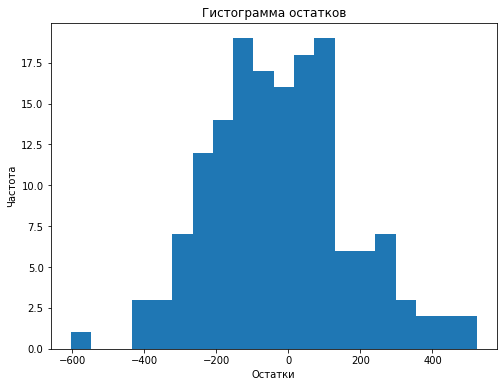

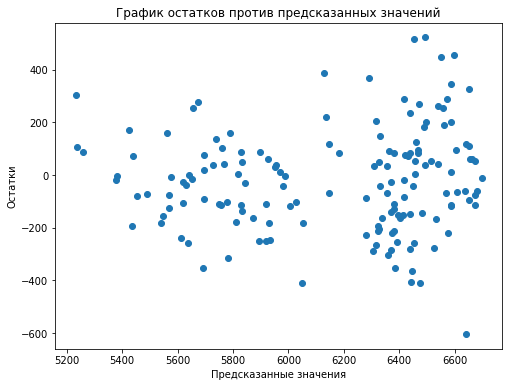

Выводы:
R² модели: 0.81
Асимметрия остатков: 0.26


In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew


# Удой,кг: ключевыми факторами, влияющими на удой, 
# являются возраст коровы(0.99) спо_категория(КК*=0.81), ЭКЕ(КК=0.72), жирность(КК=0.7), порода папы быка.
# Выбор признаков
X = ferma_main[['возраст', 'спо_категория', 'эке_(энергетическая_кормовая_единица)', 'жирность,%', 'порода_папы_быка']]
y = ferma_main['удой,_кг']

RANDOM_STATE = 42
# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

# Кодирование категориальных признаков
ohe = OneHotEncoder(handle_unknown='error', drop='first')
X_train_cat = ohe.fit_transform(X_train[['возраст', 'спо_категория', 'порода_папы_быка']]).toarray()
X_test_cat = ohe.transform(X_test[['возраст', 'спо_категория', 'порода_папы_быка']]).toarray()

# Масштабирование количественных признаков
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[['эке_(энергетическая_кормовая_единица)', 'жирность,%']])
X_test_num = scaler.transform(X_test[['эке_(энергетическая_кормовая_единица)', 'жирность,%']])

# Объединение закодированных и масштабированных данных
X_train = np.concatenate((X_train_num, X_train_cat), axis=1)
X_test = np.concatenate((X_test_num, X_test_cat), axis=1)

# Обучение модели LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred_model1 = model.predict(X_test)

# Оценка модели
r2 = r2_score(y_test, y_pred_model1)

print(f'R² модели: {r2:.2f}')

# Анализ остатков
residuals = y_test - y_pred_model1

# Гистограмма остатков
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20)
plt.title('Гистограмма остатков')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.show()

# Вычисление асимметрии
assim_ost = skew(residuals)

# График остатков против предсказанных значений
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_model1, residuals)
plt.title('График остатков против предсказанных значений')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.show()

# Выводы
print('Выводы:')
print(f'R² модели: {r2:.2f}')
print(f'Асимметрия остатков: {assim_ost:.2f}')

**Вывод**
Значение R² равно 0.81, что говорит о том, что модель объясняет около 81% изменения в целевой переменной Удой,кг. Это довольно высокое значение, что модель хорошо подходит для данных.
Гистограмма показывает, что распределение остатков бизко к нормальному, с небольшим смещением вправо, что подтверждается значением ассиметрии (0.26). Небольшое смещение вправо в распределении остатков может указывать на некоторые проблемы с моделью. Однако, учитывая небольшую асимметрию (0.26), это отклонение не является критичным.
Но есть локальные всплески. Которые тоже говорят о том, что модель можно улучшать


R² модели: 0.81


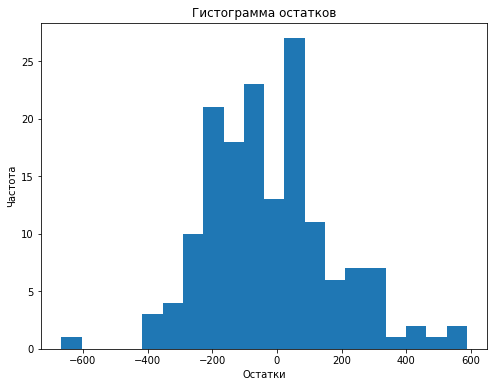

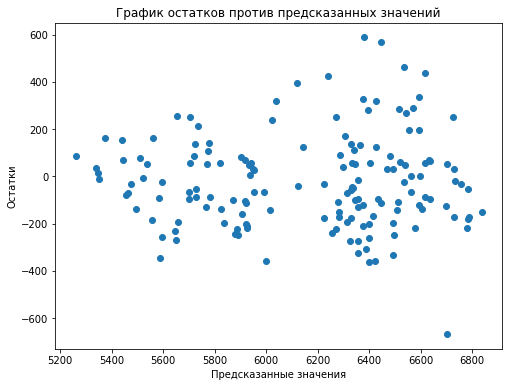

Выводы:
R² модели: 0.81
Асимметрия остатков: 0.43


In [38]:
# Добавление признака ЭКЕ в квадрате
ferma_main['эке_квадрат'] = ferma_main['эке_(энергетическая_кормовая_единица)'] ** 2

# Выбор признаков
X = ferma_main[['возраст',
                'спо_категория',
                'эке_(энергетическая_кормовая_единица)',
                'жирность,%',
                'порода_папы_быка',
                'эке_квадрат']]

y = ferma_main['удой,_кг']

RANDOM_STATE = 42

# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

# Кодирование категориальных признаков
X_train_cat = ohe.fit_transform(X_train[['возраст', 'спо_категория', 'порода_папы_быка']]).toarray()
X_test_cat = ohe.transform(X_test[['возраст', 'спо_категория', 'порода_папы_быка']]).toarray()

# Масштабирование количественных признаков
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[['эке_(энергетическая_кормовая_единица)', 'жирность,%', 'эке_квадрат']])
X_test_num = scaler.transform(X_test[['эке_(энергетическая_кормовая_единица)', 'жирность,%', 'эке_квадрат']])

# Объединение закодированных и масштабированных данных
X_train = np.concatenate((X_train_num, X_train_cat), axis=1)
X_test = np.concatenate((X_test_num, X_test_cat), axis=1)

# Обучение модели LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred_model2 = model.predict(X_test)

# Оценка модели
r2 = r2_score(y_test, y_pred_model2)

print(f'R² модели: {r2:.2f}')

# Анализ остатков
residuals = y_test - y_pred_model2

# Вычисление асимметрии
assim_ost = skew(residuals)

# Гистограмма остатков
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20)
plt.title('Гистограмма остатков')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.show()

# График остатков против предсказанных значений
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_model2, residuals)
plt.title('График остатков против предсказанных значений')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.show()

# Выводы
print('Выводы:')
print(f'R² модели: {r2:.2f}')
print(f'Асимметрия остатков: {assim_ost:.2f}')


R² модели осталось на том же уровне, а вот ассиметричность увеличилась(0.43). Модель стала работать хуже

In [39]:
print(ferma_main.shape)
print(ferma_dad.shape)

(628, 15)
(629, 2)


In [40]:
# Соединение данных
ferma_main = ferma_main.merge(ferma_dad, on='id', how='left')
ferma_main.info()
display(ferma_main.head(5))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 628 entries, 0 to 627
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   id                                     628 non-null    int64   
 1   удой,_кг                               628 non-null    int64   
 2   эке_(энергетическая_кормовая_единица)  628 non-null    float64 
 3   сырой_протеин,_г                       628 non-null    int64   
 4   спо_(сахаро-протеиновое_соотношение)   628 non-null    float64 
 5   порода                                 628 non-null    object  
 6   тип_пастбища                           628 non-null    object  
 7   порода_папы_быка                       628 non-null    object  
 8   жирность,%                             628 non-null    float64 
 9   белок,%                                628 non-null    float64 
 10  вкус_молока                            628 non-null    object 

,id,"удой,_кг",эке_(энергетическая_кормовая_единица),"сырой_протеин,_г",спо_(сахаро-протеиновое_соотношение),порода,тип_пастбища,порода_папы_быка,"жирность,%","белок,%",вкус_молока,возраст,спо_категория,жирность_категория,эке_квадрат,имя_папы
0,1,5863,14.2,1743,0.890,вис бик айдиал,равнинное,айдиал,3.58,3.076,вкусно,более_2_лет,спо_менее_0.9,Низкая,201.64,буйный
1,2,5529,12.8,2138,0.890,вис бик айдиал,равнинное,соверин,3.54,3.079,вкусно,менее_2_лет,спо_менее_0.9,Низкая,163.84,соловчик
2,3,5810,14.0,1854,0.885,рефлешн_соверинг,холмистое,соверин,3.59,3.074,не вкусно,более_2_лет,спо_менее_0.9,Низкая,196.00,барин
3,4,5895,12.4,2012,0.885,рефлешн_соверинг,холмистое,айдиал,3.40,3.075,не вкусно,более_2_лет,спо_менее_0.9,Низкая,153.76,буйный
4,5,5302,12.8,1675,0.885,вис бик айдиал,равнинное,соверин,3.73,3.073,вкусно,менее_2_лет,спо_менее_0.9,Высокая,163.84,барин


R² модели: 0.82


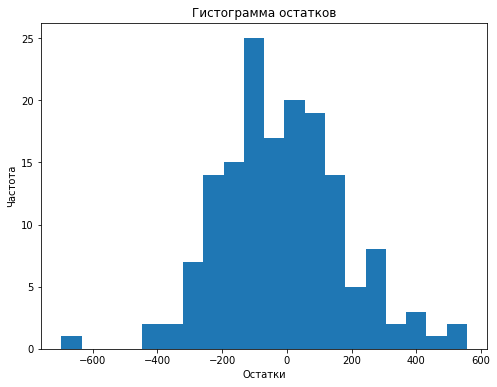

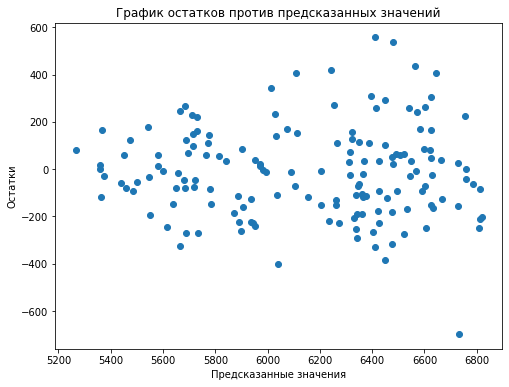

Выводы:
R² модели: 0.82
Асимметрия остатков: 0.43


In [41]:
# Выбор признаков
X = ferma_main[['возраст',
                'спо_категория',
                'эке_(энергетическая_кормовая_единица)',
                'жирность,%',
                'порода_папы_быка',
                'эке_квадрат',
                'имя_папы']]

y = ferma_main['удой,_кг']

RANDOM_STATE = 42

# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

# Кодирование категориальных признаков
X_train_cat = ohe.fit_transform(X_train[['возраст', 'спо_категория', 'порода_папы_быка', 'имя_папы']]).toarray()
X_test_cat = ohe.transform(X_test[['возраст', 'спо_категория', 'порода_папы_быка', 'имя_папы']]).toarray()

# Масштабирование количественных признаков
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[['эке_(энергетическая_кормовая_единица)', 'жирность,%', 'эке_квадрат']])
X_test_num = scaler.transform(X_test[['эке_(энергетическая_кормовая_единица)', 'жирность,%', 'эке_квадрат']])

# Объединение закодированных и масштабированных данных
X_train = np.concatenate((X_train_num, X_train_cat), axis=1)
X_test = np.concatenate((X_test_num, X_test_cat), axis=1)

# Обучение модели LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred_model3 = model.predict(X_test)

# Оценка модели
r2 = r2_score(y_test, y_pred_model3)

# Вычисление асимметрии
assim_ost = skew(residuals)

print(f'R² модели: {r2:.2f}')

# Анализ остатков
residuals = y_test - y_pred_model3

# Гистограмма остатков
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20)
plt.title('Гистограмма остатков')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.show()

# График остатков против предсказанных значений
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_model3, residuals)
plt.title('График остатков против предсказанных значений')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.show()

# Выводы
print('Выводы:')
print(f'R² модели: {r2:.2f}')
print(f'Асимметрия остатков: {assim_ost:.2f}')

Модель 1 (базовая):
    R²: 0.81
    Остатки: распределение близко к нормальному.

Модель 2 (с преобразованными признаком эке_квадрат):
    R²: 0.81 то же что и у первой модели
    Остатки: распределение остатков хуже чем у первой модели, выше ассиметричность.

Модель 3 (с добавлением Имя Папы):
    R²: 0.82
    Остатки: близкое к нормальному распределению, расположение остатков лучше чем предыдущих моделей.
    
Вывод:
Модель 3  показала наилучшие результаты:  наивысший R² и остатки, ближе всего к нормальному распределению, что указывает на  лучшее соответствие модели данным. 

In [42]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# Оценка моделей
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    return mse, mae, rmse

# Оценка модели 1 (базовая)
mse_model1, mae_model1, rmse_model1 = evaluate_model(y_test, y_pred_model1)
print('Модель 1:')
print(f'MSE: {mse_model1:.2f}')
print(f'MAE: {mae_model1:.2f}')
print(f'RMSE: {rmse_model1:.2f}')
print('------------------------------')

# Оценка модели 2 (с преобразованными признаками)
mse_model2, mae_model2, rmse_model2 = evaluate_model(y_test, y_pred_model2)
print('Модель 2:')
print(f'MSE: {mse_model2:.2f}')
print(f'MAE: {mae_model2:.2f}')
print(f'RMSE: {rmse_model2:.2f}')
print('------------------------------')

# Оценка модели 3 (с добавлением имя папы)
mse_model3, mae_model3, rmse_model3 = evaluate_model(y_test, y_pred_model3)
print('Модель 3:')
print(f'MSE: {mse_model3:.2f}')
print(f'MAE: {mae_model3:.2f}')
print(f'RMSE: {rmse_model3:.2f}')
print('------------------------------')

# Выбор лучшей модели
best_model = 3
print(f'Лучшая модель: {best_model}')
print('------------------------------')

# Рассчёт доверительного интервала прогноза
if best_model == 3: 
    y_train_pred = model.predict(X_train)
    errors = y_train - y_train_pred
    lower_quantile = np.quantile(errors, 0.025)
    upper_quantile = np.quantile(errors, 0.975)
    print(f'Доверительный интервал прогноза (95%): [{lower_quantile:.2f}, {upper_quantile:.2f}]')

Модель 1:
MSE: 38287.08
MAE: 154.87
RMSE: 195.67
------------------------------
Модель 2:
MSE: 38775.38
MAE: 156.00
RMSE: 196.91
------------------------------
Модель 3:
MSE: 37120.36
MAE: 151.11
RMSE: 192.67
------------------------------
Лучшая модель: 3
------------------------------
Доверительный интервал прогноза (95%): [-329.83, 389.29]


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


**Вывод:**

Модель 3 является лучшей из представленных по показателям и вот почему:

1. Модель 3 имеет наименьшую MSE, среднеквадратичную ошибку (37120.36), что означает, что она предсказывает удой коров с меньшими ошибками, чем две другие модели.
2. Модель 3 также имеет наименьшую MAE, среднюю абсолютную ошибку (151.11), что говорит о том, что средняя величина ошибки модели в абсолютном значении является наименьшей.
3. Модель 3 имеет наименьшую RMSE, корень среднеквадратичной ошибки (192.67), что показывает более низкую среднюю величину ошибки по сравнению с другими моделями.

Доверительный интервал показывает, что в 95% случаев предсказанный удой может быть на 329.83 кг меньше или на 389.29 кг больше фактического.

In [43]:
ferma_main.info()
print('_____________________________________')
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 628 entries, 0 to 627
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   id                                     628 non-null    int64   
 1   удой,_кг                               628 non-null    int64   
 2   эке_(энергетическая_кормовая_единица)  628 non-null    float64 
 3   сырой_протеин,_г                       628 non-null    int64   
 4   спо_(сахаро-протеиновое_соотношение)   628 non-null    float64 
 5   порода                                 628 non-null    object  
 6   тип_пастбища                           628 non-null    object  
 7   порода_папы_быка                       628 non-null    object  
 8   жирность,%                             628 non-null    float64 
 9   белок,%                                628 non-null    float64 
 10  вкус_молока                            628 non-null    object 

Подготовим выборку cow_buy, чтобы она соотвествовала по структуре нашей модели.

In [44]:
# Вычисляем средние значения признаков в ferma_main с увеличением на 5%
mean_eke = ferma_main['эке_(энергетическая_кормовая_единица)'].mean() * 1.05
mean_spo = ferma_main['спо_(сахаро-протеиновое_соотношение)'].mean() * 1.05

# Добавляем новые столбцы в cow_buy
cow_buy['эке_(энергетическая_кормовая_единица)'] = mean_eke
cow_buy['спо_(сахаро-протеиновое_соотношение)'] = mean_spo


# Вычисляем 'эке квадрат' 
cow_buy['эке_квадрат'] = cow_buy['эке_(энергетическая_кормовая_единица)'] ** 2

# Переименовываем столбец
cow_buy.rename(columns={'текущая_жирность,%': 'жирность,%'}, inplace=True) 

# Функция pd.cut() из библиотеки pandas используется для разбиения данных на категории.
cow_buy['спо_категория'] = pd.cut(cow_buy['спо_(сахаро-протеиновое_соотношение)'], 
                                        bins=[0.84, 0.92, 0.96], 
                                        labels=['спо_менее_0.9', 'спо_более_0.9'],
                                        include_lowest=True) # нижняя граница первого интервала должна включаться в категорию
cow_buy.info()
display(cow_buy.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   порода                                 20 non-null     object  
 1   тип_пастбища                           20 non-null     object  
 2   порода_папы_быка                       20 non-null     object  
 3   имя_папы                               20 non-null     object  
 4   жирность,%                             20 non-null     float64 
 5   текущий_уровень_белок,%                20 non-null     float64 
 6   возраст                                20 non-null     object  
 7   эке_(энергетическая_кормовая_единица)  20 non-null     float64 
 8   спо_(сахаро-протеиновое_соотношение)   20 non-null     float64 
 9   эке_квадрат                            20 non-null     float64 
 10  спо_категория                          20 non-null     category


,порода,тип_пастбища,порода_папы_быка,имя_папы,"жирность,%","текущий_уровень_белок,%",возраст,эке_(энергетическая_кормовая_единица),спо_(сахаро-протеиновое_соотношение),эке_квадрат,спо_категория
0,вис бик айдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет,15.276162,0.958744,233.361138,спо_более_0.9
1,вис бик айдиал,равнинное,соверин,буйный,3.54,3.081,менее_2_лет,15.276162,0.958744,233.361138,спо_более_0.9
2,рефлешн_соверинг,равнинное,соверин,барин,3.59,3.074,более_2_лет,15.276162,0.958744,233.361138,спо_более_0.9
3,рефлешн_соверинг,холмистое,айдиал,буйный,3.40,3.061,более_2_лет,15.276162,0.958744,233.361138,спо_более_0.9
4,рефлешн_соверинг,равнинное,айдиал,буйный,3.64,3.074,более_2_лет,15.276162,0.958744,233.361138,спо_более_0.9
5,рефлешн_соверинг,равнинное,соверин,геркулес,3.63,3.053,менее_2_лет,15.276162,0.958744,233.361138,спо_более_0.9
6,вис бик айдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет,15.276162,0.958744,233.361138,спо_более_0.9
7,вис бик айдиал,равнинное,соверин,буйный,3.57,3.079,более_2_лет,15.276162,0.958744,233.361138,спо_более_0.9
8,рефлешн_соверинг,равнинное,соверин,барин,3.59,3.074,более_2_лет,15.276162,0.958744,233.361138,спо_более_0.9
9,рефлешн_соверинг,холмистое,айдиал,буйный,3.40,3.079,менее_2_лет,15.276162,0.958744,233.361138,спо_более_0.9


In [45]:
# Выбор признаков для cow_buy
X_cow_buy = cow_buy[['возраст',
                     'спо_категория',
                     'эке_(энергетическая_кормовая_единица)',
                     'жирность,%',
                     'порода_папы_быка',
                     'эке_квадрат',
                     'имя_папы']]

# Подготовка данных cow_buy
# Кодирование категориальных признаков
X_cow_buy_cat = ohe.transform(X_cow_buy[['возраст', 'спо_категория', 'порода_папы_быка', 'имя_папы']]).toarray()

# Масштабирование количественных признаков
X_cow_buy_num = scaler.transform(X_cow_buy[['эке_(энергетическая_кормовая_единица)', 'жирность,%', 'эке_квадрат']])

# Объединение закодированных и масштабированных данных
X_cow_buy = np.concatenate((X_cow_buy_num, X_cow_buy_cat), axis=1)

# Получение прогноза удоя
y_pred_cow_buy = model.predict(X_cow_buy)

# Вывод прогнозов
print(f"Прогноз удоя для коров из cow_buy.csv: \n{y_pred_cow_buy}")

Прогноз удоя для коров из cow_buy.csv: 
[6495.93353975 6256.10065519 6238.50217317 6444.13673924 6518.81212249
 6279.89418698 6495.93353975 6500.09169045 6238.50217317 6209.48012688
 6306.70276738 6545.66554236 6527.04828278 5950.95049767 6238.50217317
 6444.13673924 6306.70276738 6323.45482721 6428.5277815  6518.81212249]


Новый Вывод: все коровы дают удой свыше 6000 кг в год, кроме коровы под порядковым номером 14 (5950.95). Хотя удой коровы 14  очень близок к целевому показателю. 

## Обучение модели логистической регрессии

In [46]:
ferma_main.info()
display(ferma_main.head(5))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 628 entries, 0 to 627
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   id                                     628 non-null    int64   
 1   удой,_кг                               628 non-null    int64   
 2   эке_(энергетическая_кормовая_единица)  628 non-null    float64 
 3   сырой_протеин,_г                       628 non-null    int64   
 4   спо_(сахаро-протеиновое_соотношение)   628 non-null    float64 
 5   порода                                 628 non-null    object  
 6   тип_пастбища                           628 non-null    object  
 7   порода_папы_быка                       628 non-null    object  
 8   жирность,%                             628 non-null    float64 
 9   белок,%                                628 non-null    float64 
 10  вкус_молока                            628 non-null    object 

,id,"удой,_кг",эке_(энергетическая_кормовая_единица),"сырой_протеин,_г",спо_(сахаро-протеиновое_соотношение),порода,тип_пастбища,порода_папы_быка,"жирность,%","белок,%",вкус_молока,возраст,спо_категория,жирность_категория,эке_квадрат,имя_папы
0,1,5863,14.2,1743,0.890,вис бик айдиал,равнинное,айдиал,3.58,3.076,вкусно,более_2_лет,спо_менее_0.9,Низкая,201.64,буйный
1,2,5529,12.8,2138,0.890,вис бик айдиал,равнинное,соверин,3.54,3.079,вкусно,менее_2_лет,спо_менее_0.9,Низкая,163.84,соловчик
2,3,5810,14.0,1854,0.885,рефлешн_соверинг,холмистое,соверин,3.59,3.074,не вкусно,более_2_лет,спо_менее_0.9,Низкая,196.00,барин
3,4,5895,12.4,2012,0.885,рефлешн_соверинг,холмистое,айдиал,3.40,3.075,не вкусно,более_2_лет,спо_менее_0.9,Низкая,153.76,буйный
4,5,5302,12.8,1675,0.885,вис бик айдиал,равнинное,соверин,3.73,3.073,вкусно,менее_2_лет,спо_менее_0.9,Высокая,163.84,барин


In [47]:
# Преобразование "Вкус молока" в бинарный признак
# from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
# Кодируем целевой признак
ferma_main['вкус_молока'] = LE.fit_transform(ferma_main['вкус_молока'])
# Инвертирование классов
ferma_main['вкус_молока'] = 1 - ferma_main['вкус_молока']
display(ferma_main['вкус_молока'].head(5))

0    1
1    1
2    0
3    0
4    1
Name: вкус_молока, dtype: int64

interval columns not set, guessing: ['удой,_кг', 'эке_(энергетическая_кормовая_единица)', 'сырой_протеин,_г', 'спо_(сахаро-протеиновое_соотношение)', 'жирность,%', 'белок,%', 'вкус_молока', 'эке_квадрат']


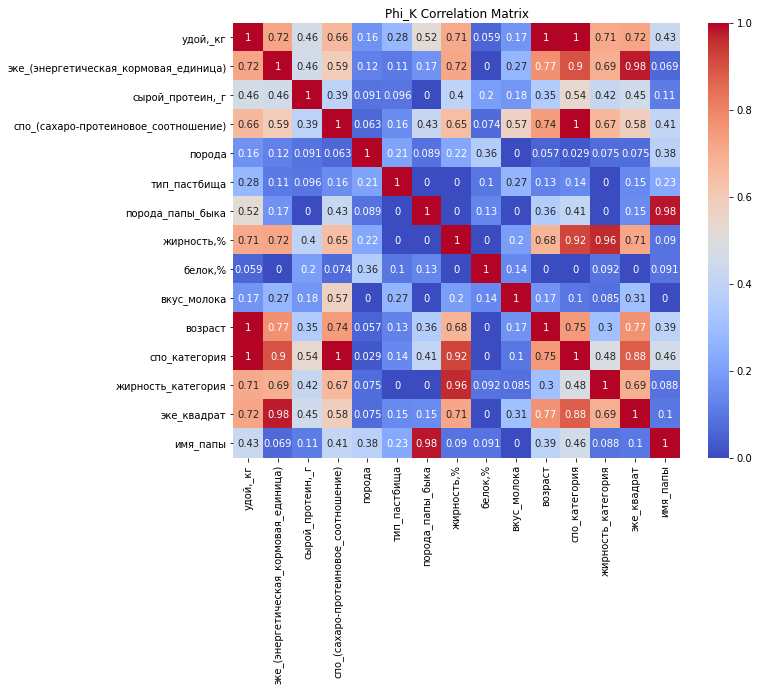

In [48]:
# Исключим столбец 'id' из корреляции
ferma_main_corr = ferma_main.drop('id', axis=1)

# Вычисление  матрицы  корреляции:
corr_matrix = ferma_main_corr.phik_matrix()

# Визуализация  матрицы  корреляции:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

In [49]:
print(corr_matrix['вкус_молока'])

удой,_кг                                 0.173122
эке_(энергетическая_кормовая_единица)    0.272265
сырой_протеин,_г                         0.176480
спо_(сахаро-протеиновое_соотношение)     0.572702
порода                                   0.000000
тип_пастбища                             0.269063
порода_папы_быка                         0.000000
жирность,%                               0.198793
белок,%                                  0.143857
вкус_молока                              1.000000
возраст                                  0.165974
спо_категория                            0.100949
жирность_категория                       0.084561
эке_квадрат                              0.305768
имя_папы                                 0.000000
Name: вкус_молока, dtype: float64


**Вывод:**

Основываясь на полученной матрице корреляции, мы выбрали следующие входные признаки для модели логистической регрессии:
- спо_(сахаро-протеиновое_соотношение)(КК = 0.57)
- эке_квадрат(КК = 0.31)
- эке_(энергетическая_кормовая_единица)(КК = 0.27)
- тип_пастбища(КК = 0.27)
- жирность,%(КК = 0.2)
- возраст(КК = 0.17)

Остальные признаки не демонстрируют значимой линейной корреляции с вкусом молока.

Точность модели (accuracy): 0.61
Полнота модели (recall): 0.83
Точность модели (precision): 0.61


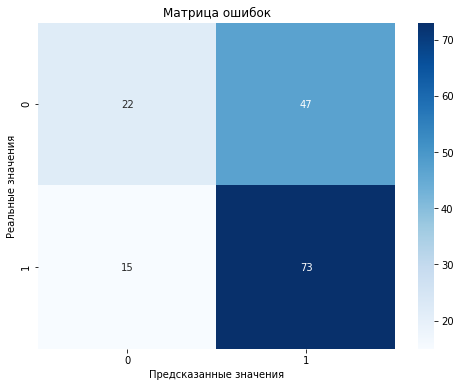


Матрица ошибок:
[[22 47]
 [15 73]]


In [50]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

# спо_(сахаро-протеиновое_соотношение)(КК = 0.57)
# эке_квадрат(КК = 0.31)
# эке_(энергетическая_кормовая_единица)(КК = 0.27)
# тип_пастбища(КК = 0.27)
# жирность,%(КК = 0.2)
# возраст(КК = 0.17)

# Выбор признаков
X = ferma_main[[
    'спо_(сахаро-протеиновое_соотношение)',
    'эке_квадрат',
    'эке_(энергетическая_кормовая_единица)',
    'тип_пастбища',
    'жирность,%',
    'возраст'
]]
y = ferma_main['вкус_молока']

RANDOM_STATE = 42

# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

# Кодирование категориальных признаков
X_train_cat = ohe.fit_transform(X_train[['тип_пастбища', 'возраст']]).toarray()
X_test_cat = ohe.transform(X_test[['тип_пастбища', 'возраст']]).toarray()

# Масштабирование количественных признаков
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[['спо_(сахаро-протеиновое_соотношение)',
                                            'эке_квадрат',
                                            'эке_(энергетическая_кормовая_единица)',
                                            'жирность,%']])
X_test_num = scaler.transform(X_test[['спо_(сахаро-протеиновое_соотношение)',
                                      'эке_квадрат',
                                      'эке_(энергетическая_кормовая_единица)',
                                      'жирность,%']])

# Объединение закодированных и масштабированных данных
X_train = np.concatenate((X_train_num, X_train_cat), axis=1)
X_test = np.concatenate((X_test_num, X_test_cat), axis=1)

# Обучение модели LogisticRegression
model = LogisticRegression(random_state=RANDOM_STATE)
model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_test)

# Оценка модели
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f'Точность модели (accuracy): {accuracy:.2f}')
print(f'Полнота модели (recall): {recall:.2f}')
print(f'Точность модели (precision): {precision:.2f}')

# Построение матрицы ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок')
plt.xlabel('Предсказанные значения')
plt.ylabel('Реальные значения')
plt.show()

# Вывод значений матрицы ошибок
print("\nМатрица ошибок:")
print(cm)

Вывод:
 - Точность (Accuracy): 0.61. Не высокая. Модель правильно классифицирует около 61% случаев.
 - Полнота (Recall): 0.83. что модель правильно определяет 32% случаев вкусного молока.
 - Точность (Precision): 0.61. Не высокая. Модель часто ошибочно классифицирует не вкусное молоко как вкусное.
 
Матрица ошибок:
 - Модель правильно классифицирует больше вкусного молока (73 случаев), чем не вкусного (22 случаев).
 - У модели  есть ложные положительные результаты (47 случаев не вкусного молока были ошибочно классифицированы как вкусные).

## Анализ модели логистической регрессии:
**Ошибка первого рода:** Модель предсказывает, что молоко вкусное, когда оно на самом деле не вкусное.

**Ошибка второго рода:** Модель предсказывает, что молоко не вкусное, когда оно на самом деле вкусное.

**Критическая ошибка:**

В данном случае критичнее ошибка первого рода, то есть предсказать, что молоко “вкусное”, когда оно на самом деле “не вкусное”.

**Почему?**

Фермеру крайне важно, чтобы молоко было вкусным. Если модель ошибочно предскажет, что молоко вкусное, фермер может купить корову, молоко которой на самом деле окажется невкусным.

**Важность метрик:**

**Recall (полнота):** Измеряет, сколько “вкусного” молока модель правильно классифицировала.
<br>**Precision (точность):** Измеряет, сколько “вкусных” предсказаний модели действительно были правильными.

В данном случае, **Recall (полнота)** более важна, так как фермер хочет, чтобы модель максимально точно определяла “вкусное” молоко.

**Изменение порога принадлежности к классам:**

Чтобы свести к минимуму ошибку первого рода, нужно повысить precision модели.

**Как изменить порог?**

1. В модели LogisticRegression порог классификации по умолчанию равен 0.5. Это означает, что если вероятность того, что молоко “вкусное”, больше 0.5, то модель предсказывает “вкусно”.
2. Чтобы уменьшить ошибку первого рода, нужно повысить порог (например, до 0.7 или 0.8). Это уменьшит количество ложных положительных результатов, но может увеличить количество ложных отрицательных результатов (ошибки второго рода).

Точность модели (accuracy): 0.50
Полнота модели (recall): 0.11
Точность модели (precision): 1.00


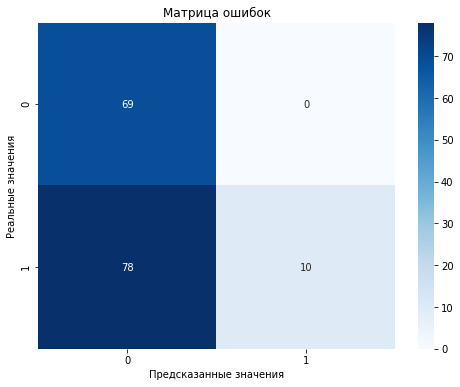


Матрица ошибок:
[[69  0]
 [78 10]]


In [51]:
# Изменение порога
threshold = 0.78 

# Предсказание с новым порогом
# Вероятность принадлежности к классу "вкусно"
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Применяем порог
y_pred = (y_pred_proba >= threshold).astype(int)  

# Перерасчет метрик
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f'Точность модели (accuracy): {accuracy:.2f}')
print(f'Полнота модели (recall): {recall:.2f}')
print(f'Точность модели (precision): {precision:.2f}')

# Построение матрицы ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок')
plt.xlabel('Предсказанные значения')
plt.ylabel('Реальные значения')
plt.show()

# Вывод значений матрицы ошибок
print("\nМатрица ошибок:")
print(cm)

In [52]:
cow_buy.info()
display(cow_buy.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   порода                                 20 non-null     object  
 1   тип_пастбища                           20 non-null     object  
 2   порода_папы_быка                       20 non-null     object  
 3   имя_папы                               20 non-null     object  
 4   жирность,%                             20 non-null     float64 
 5   текущий_уровень_белок,%                20 non-null     float64 
 6   возраст                                20 non-null     object  
 7   эке_(энергетическая_кормовая_единица)  20 non-null     float64 
 8   спо_(сахаро-протеиновое_соотношение)   20 non-null     float64 
 9   эке_квадрат                            20 non-null     float64 
 10  спо_категория                          20 non-null     category


,порода,тип_пастбища,порода_папы_быка,имя_папы,"жирность,%","текущий_уровень_белок,%",возраст,эке_(энергетическая_кормовая_единица),спо_(сахаро-протеиновое_соотношение),эке_квадрат,спо_категория
0,вис бик айдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет,15.276162,0.958744,233.361138,спо_более_0.9
1,вис бик айдиал,равнинное,соверин,буйный,3.54,3.081,менее_2_лет,15.276162,0.958744,233.361138,спо_более_0.9
2,рефлешн_соверинг,равнинное,соверин,барин,3.59,3.074,более_2_лет,15.276162,0.958744,233.361138,спо_более_0.9
3,рефлешн_соверинг,холмистое,айдиал,буйный,3.40,3.061,более_2_лет,15.276162,0.958744,233.361138,спо_более_0.9
4,рефлешн_соверинг,равнинное,айдиал,буйный,3.64,3.074,более_2_лет,15.276162,0.958744,233.361138,спо_более_0.9


In [53]:
# # Выбор признаков
# X = ferma_main[[
#     'спо_(сахаро-протеиновое_соотношение)',
#     'эке_квадрат',
#     'эке_(энергетическая_кормовая_единица)',
#     'тип_пастбища',
#     'жирность,%',
#     'возраст'
# ]]
# y = ferma_main['вкус_молока']

# Выбор признаков
X_cow_buy = cow_buy[['спо_(сахаро-протеиновое_соотношение)',
                     'эке_квадрат',
                     'эке_(энергетическая_кормовая_единица)',
                     'тип_пастбища',
                     'жирность,%',
                     'возраст']]

# Масштабирование количественных признаков
X_cow_buy_num = scaler.transform(X_cow_buy[['спо_(сахаро-протеиновое_соотношение)',
                                            'эке_квадрат',
                                            'эке_(энергетическая_кормовая_единица)',
                                            'жирность,%']])

# Кодирование категориальных признаков
X_cow_buy_cat = ohe.transform(X_cow_buy[['тип_пастбища', 'возраст']]).toarray()

# Объединение закодированных и масштабированных данных
X_cow_buy = np.concatenate((X_cow_buy_num, X_cow_buy_cat), axis=1)

# Прогнозирование вкуса молока
y_pred_cow_buy = model.predict(X_cow_buy)

# Вывод прогнозов
print(f"Прогноз вкуса молока для коров из cow_buy.csv: \n{y_pred_cow_buy}")

# Вывод прогнозов с расшифровкой
for i, prediction in enumerate(y_pred_cow_buy):
    if prediction == 1:
        print(f"Корова {i+1}: Вкусное молоко")
    else:
        print(f"Корова {i+1}: Не вкусное молоко")

Прогноз вкуса молока для коров из cow_buy.csv: 
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Корова 1: Вкусное молоко
Корова 2: Вкусное молоко
Корова 3: Вкусное молоко
Корова 4: Вкусное молоко
Корова 5: Вкусное молоко
Корова 6: Вкусное молоко
Корова 7: Вкусное молоко
Корова 8: Вкусное молоко
Корова 9: Вкусное молоко
Корова 10: Вкусное молоко
Корова 11: Вкусное молоко
Корова 12: Вкусное молоко
Корова 13: Вкусное молоко
Корова 14: Вкусное молоко
Корова 15: Вкусное молоко
Корова 16: Вкусное молоко
Корова 17: Вкусное молоко
Корова 18: Вкусное молоко
Корова 19: Вкусное молоко
Корова 20: Вкусное молоко


**Вывод.**

Все коровы дают вкусное молоко!

## Итоговые выводы

**Предобработка данных**
1. Заменены запятые на точки в числовых столбцах датафреймов ferma_main и cow_buy.
2. Изменен тип данных в этих столбцах с object на float.
3. Унифицированы названия столбцов в датафреймах: приведены к нижнему регистру в стиде snake_case.
4. Обнаружены и удалены дубликаты из ferma_main.

**Исследовательский анализ**
1. Обнаружено и удалено аномальное значение в столбце “Удой,_кг” 
2. Проведен анализ гистограмм полей ds,jhrb ferma_main.csv:
   - Удой, кг: Данные распределены практически симметрично близко к нормальному распределению
   - ЭКЕ (энергетическая кормовая единица): Распределение немного смещено в сторону более низких значений, но вариативность небольшая
   - Сырой протеин, г: Распределение немного смещено в сторону более высоких значений
   - СПО (Сахаро-протеиновое соотношение): Распределение смещено в сторону более низких значений. На гистограмме четко видно как значения разделены на несколько отдельных групп. С учетом всех данных имеет смысл этот столбец перевести в категориальную шкалу
   - Жирность, %: Очень высокая ассиметрия. Распределение сильно смещено в сторону более низких значений, что подтверждается блокспотом. С учетом всех данных имеет смысл этот столбец перевести в категориальную шкалу
   - Белок, %: Распределение практически симметричное и очень стабильное
3. На основе столбцов числовых СПО и Жирность, созданы новые категориальные признаки 'спо_категория' и 'жирность_категория'

**Корреляционный анализ**

Нам болле остальных важны 2 целевых признака: удой и вкус молока. На основе полученных данных сделаны следующие выводы о коррелляции этих признаков с другими.
   - Удой,кг: ключевыми факторами, влияющими на удой, являются возраст коровы(0.99) спо_категория(КК*=0.81), ЭКЕ(КК=0.72), жирность(КК=0.7), СПО(КК=0.66).
   - Вкус молока: не наблюдается сильных взаимосвязей вкуса молока сдругими признаками. Вкус молока связан с СПО(КК=0.57), но связь также не сильная.
   
**Модель линейной регрессии**
Получившаяся модель имеет следующие показатели:
   - R²: 0.82 означает, что модель может объяснить 82% изменения целевой переменной (удоя) с помощью выбранных признаков.
   - MSE(среднеквадратичная ошибка):37120.36
   - RMSE(орень среднеквадратичной ошибки):192.67 означает в среднем ошибка предсказания удоя составляет около 192.67 кг.
   - MAE(среднюю абсолютную ошибку):151.11 означает, что в среднем ошибка предсказания удоя составляет около 151.11 кг. Этот показатель менее чувствителен к выбросам, чем MSE и RMSE.
   - Доверительный интервал показывает, что в 95% случаев предсказанный удой может быть на 329.83 кг меньше или на 389.29 кг больше фактического.
   
   Модель линейной регрессии, обученная на имеющихся данных, показала, что все коровы в стаде должны иметь удой свыше 6000 кг в год, за исключением коровы под порядковым номером 14, для которой модель предсказала удой 5950.95 кг.
   
**Модель логистической регрессии**
Получившаяся модель имела следующие исходные показатели:
   - Точность (Accuracy): 0.61
   - Полнота (Recall): 0.32
   - Точность (Precision): 0.61
   - Модель правильно классифицировала больше “вкусного” молока (73 случая), чем “невкусного” (22 случая). У модели были ложные положительные результаты (47 случаев “невкусного” молока были ошибочно классифицированы как “вкусные”)
   
По условиям задания на надо было минимизировать ошибку первого рода, когда модель могла предсказать не вкусное молоко как вкусное. Для минимизации ошибки первого рода в моделе был изменен порог классификации объектов с 0.5 на 0.78.
После изменения порога модель емеет следующие показатели:
   - Точность (Accuracy): 0.50
   - Полнота (Recall): 0.11
   - Точность (Precision): 1.00
Модель логистической регрессии, обученная на имеющихся данных, показала, что все коровы в стаде должны давать вкусное молоко.

**Общий вывод на основе результатов обеих моделей:**

Модели предсказали, что все коровы кроме №14 дают вкусное молоко и имеют удой выше 6000 кг, соответственно можно купить всех коров, кроме №14, с минимальным риском

**Какие способы улучшения качества регрессионной модели вы использовали в этой задаче?**
   - отбор признаков: использовалась корреляционная матрица и диаграммы разброса для отбора признаков, влияющих на целевой признак
   - создание новых признаков: были созданы новые категориальные признаки ("спо_категория", "жирность_категория") из числовых данных для учета нелинейных зависимостей
   - изменение порогового значения: порог был изменен в модели логистической регрессии для улучшения точности (precision), чтобы снизить количество ошибок первого рода
   
**Возможно ли ещё улучшить результаты регрессионной модели? Если можно, то как? Если нет, то почему?**
Для улучшения результатов модели регрессии можно использовать следующие методы:
   - добавление в модель новых данных
   - добавление новых признаков
   - эксперементировать с разным набором входных признаков
   - попробовать методы регуляризации, чтобы уменьшить переобучение модели
   
**Какие метрики моделей классификации, в том числе логистической регрессии, важны при анализе рисков или экономических расчётов?**
   - Recall (полнота): важно для минимизации количества пропущенных случаев вкусного молока. Также нарпимер используется при минимизации невявленных случаев болезни в медицине по входным признакам (симптомам) 
   - Precision (точность): важно для минимизации количества неправильных предсказаний вкусного молока (часто используется в рекламе).
